# 实验四：多分类问题过拟合问题（$L_2$正则化方法）
姓名：王恩泰

学号：21114019

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

## 1. 读取数据集

In [7]:
# 训练集
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets', train=True,
                                                download=False, transform=transforms.ToTensor())
# 测试集
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets', train=False,
                                                download=False, transform=transforms.ToTensor())

# 通过DataLoader读取小批量数据样本
batch_size = 256
num_workers = 0
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,
num_workers=num_workers)

## 2. 构建神经网络

In [8]:
# 1. 初始化模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
w1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
w2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float)
b2 = torch.ones(num_outputs, dtype=torch.float)

params = [w1, b1, w2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

# 2. 定义激活函数
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

# 3. 定义网络
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, w1.t()) + b1)
    return torch.matmul(H, w2.t()) + b2

# 4. 交叉熵损失函数（不能用平方误差）
# def loss_func(y_true, y_predict):
#     loss = ((y_true - y_predict.view(y_true.size())) ** 2) / 2
#     return loss
loss = torch.nn.CrossEntropyLoss()

# 5.梯度下降
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad 

# 6. l2正则项
def l2_penalty(w1, w2):
    return (w1**2).sum() / 2 + (w2**2).sum() / 2

## 3. 训练模型 ($\lambda$=1)

iter: 0, train_loss= 0.009660, test_loss= 0.008412
iter: 0, train_acc= 0.235633, test_acc= 0.196500
iter: 10, train_loss= 0.009010, test_loss= 0.008845
iter: 10, train_acc= 0.200583, test_acc= 0.234800
iter: 20, train_loss= 0.009006, test_loss= 0.008874
iter: 20, train_acc= 0.203467, test_acc= 0.194900
iter: 29, train_loss= 0.009007, test_loss= 0.008870
iter: 29, train_acc= 0.204150, test_acc= 0.221100


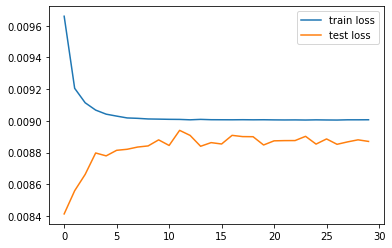

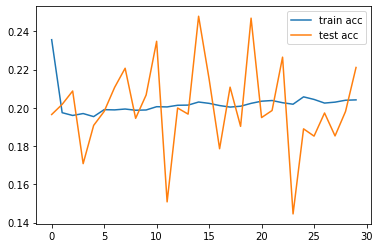

In [13]:
num_epochs = 30
lr = 0.1
# batch_size = 10
optimizer = None
lambda_value = 1
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0

    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = (loss(y_hat, train_y) + lambda_value * l2_penalty(w1, w2)).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == train_y).sum().item()
    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.argmax(dim=1) == test_y).sum().item()
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()

## 4. 训练模型 ($\lambda$=0.5)

iter: 0, train_loss= 0.008547, test_loss= 0.007420
iter: 0, train_acc= 0.289600, test_acc= 0.328600
iter: 10, train_loss= 0.008293, test_loss= 0.006992
iter: 10, train_acc= 0.428800, test_acc= 0.395300
iter: 20, train_loss= 0.008291, test_loss= 0.007009
iter: 20, train_acc= 0.428517, test_acc= 0.406400
iter: 29, train_loss= 0.008291, test_loss= 0.007000
iter: 29, train_acc= 0.427300, test_acc= 0.425700


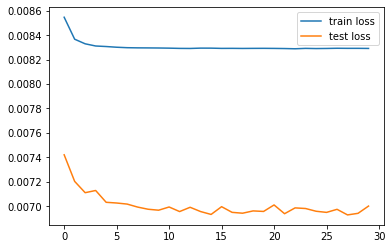

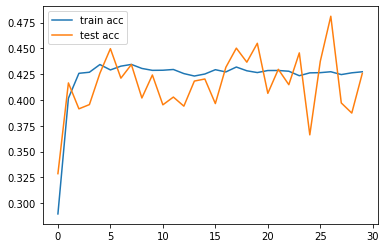

In [10]:
num_epochs = 30
lr = 0.1
# batch_size = 10
optimizer = None
lambda_value = 0.5
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0

    n_train = 0
    for train_x,train_y in train_iter: 
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = (loss(y_hat, train_y) + lambda_value * l2_penalty(w1, w2)).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == train_y).sum().item()
    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.argmax(dim=1) == test_y).sum().item()
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()

## 5. 训练模型 ($\lambda$=0.25)

iter: 0, train_loss= 0.007293, test_loss= 0.006116
iter: 0, train_acc= 0.471767, test_acc= 0.459000
iter: 10, train_loss= 0.007074, test_loss= 0.005282
iter: 10, train_acc= 0.626583, test_acc= 0.624700
iter: 20, train_loss= 0.007074, test_loss= 0.005206
iter: 20, train_acc= 0.632350, test_acc= 0.639300
iter: 29, train_loss= 0.007074, test_loss= 0.005140
iter: 29, train_acc= 0.629350, test_acc= 0.607900


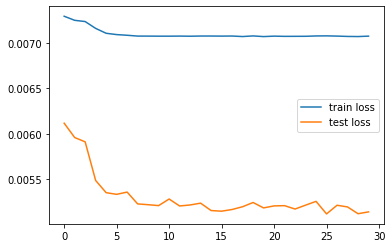

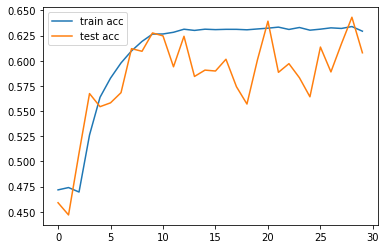

In [11]:
num_epochs = 30
lr = 0.1
# batch_size = 10
optimizer = None
lambda_value = 0.25
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0

    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = (loss(y_hat, train_y) + lambda_value * l2_penalty(w1, w2)).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == train_y).sum().item()
    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.argmax(dim=1) == test_y).sum().item()
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()

## 6. 训练模型 ($\lambda$=0.125)

iter: 0, train_loss= 0.005729, test_loss= 0.003962
iter: 0, train_acc= 0.681717, test_acc= 0.700100
iter: 10, train_loss= 0.005662, test_loss= 0.003978
iter: 10, train_acc= 0.705850, test_acc= 0.664500
iter: 20, train_loss= 0.005659, test_loss= 0.003852
iter: 20, train_acc= 0.707250, test_acc= 0.709800
iter: 29, train_loss= 0.005660, test_loss= 0.003924
iter: 29, train_acc= 0.707433, test_acc= 0.687200


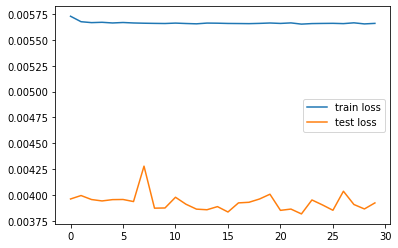

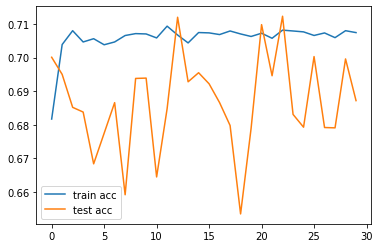

In [12]:
num_epochs = 30
lr = 0.1
# batch_size = 10
optimizer = None
lambda_value =0.125
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0

    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = (loss(y_hat, train_y) + lambda_value * l2_penalty(w1, w2)).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == train_y).sum().item()
    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.argmax(dim=1) == test_y).sum().item()
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()